In [2]:
#imports
import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns
from brainglobe_atlasapi.bg_atlas import BrainGlobeAtlas
from brainrender import Scene
from brainrender.actors import Neuron
import vedo

In [ ]:
#function definitions
def drop_by_thresh(df, thresh):
    '''
    this is written to drop columns of a data frame that have a sum value of below the input threshold
    df: pandas.DataFrame
    thresh: float
    returns: pandas.DataFrame
    '''
    sum_df = df.apply(np.sum, axis=0)
    mask = sum_df < thresh
    low_endpoint_regions = sum_df[mask].index
    return df.drop(low_endpoint_regions, axis=1)

def load_data_from_dir(direct):
    '''
    load data from a directory into a pandas DataFrame, replaces NaNs with 0s for the purpose of this notebook
    dir: string
    returns: pandas.DataFram
    '''
    data = pd.DataFrame()
    print('Loading files:')
    for file in tqdm(os.listdir(direct)):
        filename = os.path.join(direct, file)
        df = pd.read_csv(filename, header=None)
        df[0] = df[0] + df[1]
        df[1] = df[2]
        del df[2]
        df = df.loc[(df!=0).any(axis=1)]
        df_t = df.transpose()
        file = file.replace('_freq.csv','')
        file = file.replace('_length.csv', '')
        df_t = df_t.rename(index={1: file})
        df_t.columns = df_t.iloc[0]
        df_t = df_t.drop([0])
        data = pd.concat([data, df_t], join='outer')
    data_nonan = data.replace(np.nan, 0)
    return data_nonan

def preprocess(df):
    '''
    preprocess data however I want to, accepts a pandas.DataFrame with no NaNs
    df: pandas.DataFrame
    returns: pandas.DataFrame
    '''
    #remove zero variance columns
    selector = VarianceThreshold(threshold=0.0).set_output(transform='pandas')
    df = selector.fit_transform(df)
    
    #filter out regions that have less than 3 endpoints labeled in that region
    # data_thresh = drop_by_thresh(df, 3)
    # data_toln = data_thresh.copy()
    data_toln = df.copy()

    #natural log scale my data, formula of ln(number of terminals + 1) as per Ding et al. 2025
    for i, row in data_toln.iterrows():
        data_toln.loc[i] = row.map(lambda x: np.log(x+1))

    return data_toln

def cluster_and_plot(df, row_colors=None, **plot_info):
    '''
    hierarchically cluster and plot data using seaborn.clustermap using euclidean distance with ward's linkage
    df: pandas.DataFrame
    plot_info: matplotlib kwargs
    returns: None
    '''
    
    cmap = sns.clustermap(df, 
                  method='ward', 
                  metric='euclidean', 
                  row_cluster=False,
                  dendrogram_ratio=(.1, .15),
                  cbar_pos=(0, .15, .03, .7),
                  cbar_kws={'label': 'ln(terminals in region + 1)'},
                  yticklabels=True,
                  xticklabels=True,
                  row_colors=row_colors)
    
    return cmap

def merge_region_counts(list1, list2):
    # thanks deepseek
    # Create a dictionary to aggregate counts
    region_counts = {}
    
    # Process first list
    for region, count in list1:
        region_counts[region] = region_counts.get(region, 0) + count
    
    # Process second list
    for region, count in list2:
        region_counts[region] = region_counts.get(region, 0) + count
    
    # Convert back to list of tuples
    merged_list = [(region, count) for region, count in region_counts.items()]
    
    return merged_list

In [5]:
#import allen atlas
ccf_v3_10um = BrainGlobeAtlas('allen_mouse_10um')

In [107]:
ccf_v3_10um.structures["CB"]["structure_id_path"]

[997, 8, 512]

In [8]:
#have to change swc coords so this renders correctly, swap x and y around i think?
#will do another time though, not in a rush since i can render in SNT
vedo.settings.default_backend='vtk'
ccf_scene = Scene(atlas_name='allen_mouse_10um')
N032_674185 = Neuron(neuron=r'C:\Users\samkr\OneDrive\Documents\BU\AllenExASPIM\medulla_IRN_PRN_PGRN\json_swc\swc\N032-674185-IB.swc')
ccf_scene.add(N032_674185)
ccf_scene.render(camera='frontal') 

In [10]:
#data input
#on my PC in lab dir is C:\Users\samkr\OneDrive\Documents\Code\reconstructions\SNT_histos\SNT_histos\frequency
#on shared PC its ...
frequency_dir = input('Input directory with region frequency data: ') #C:\Users\samkr\OneDrive\Documents\Code\reconstructions\SNT_histos\SNT_histos\frequency
#length_dir = input('Input directory with region length data: ') #C:\Users\samkr\OneDrive\Documents\Code\reconstructions\SNT_histos\SNT_histos\length

In [11]:
#load frequency and length data in
frequency_data = load_data_from_dir(frequency_dir)
#length_data = load_data_from_dir(length_dir)
#print("Column variances:", np.var(data, axis=0))

Loading files:


100%|██████████| 69/69 [00:01<00:00, 56.87it/s]
C:\Users\samkr\AppData\Local\Temp\ipykernel_35356\3716006280.py:36: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_nonan = data.replace(np.nan, 0)


In [ ]:
#list of mossy fibers to separate later (REP WITH BRAINGLOBE ATLAS API SEARCH FOR CELLS PROJ TO CB)
#mossy_list = ['N012-674185', 'N123-708369', 'N017-715345', 'N024-715345', 'N035-674191', 

In [12]:
selector = VarianceThreshold(threshold=0.0).set_output(transform='pandas')
df_tosum = selector.fit_transform(frequency_data)

In [18]:
df_summed = df_tosum.sum(axis=0)
print(type(df_tosum))
# mask = df_summed > 10
# df_summed = df_summed[mask]
#df_summed = np.sort(df_summed)

<class 'pandas.core.frame.DataFrame'>


In [89]:
#merge the same regions from different hemispheres
zipped_regions = zip(df_tosum.keys(), df_summed)
regions_c = []
regions_i = []
for region, value in zipped_regions:
    #print(region, value)
    expi = 'Ipsilateral'
    expc = 'Contralateral'
    if expi in region:
        reg = region.replace(expi+' ', '')
        regions_i.append((reg, value))
    if expc in region:
        reg2 = region.replace(expc+' ', '')
        regions_c.append((reg2, value))
# print(regions_i)
# print(regions_c)
#check to be sure i didn't lose regions when doing this (not very robust tho)
# for ii in regions_i:
#     ri, vi = ii
#     for ic in regions_c:
#         rc, vc = ic
#         if ri == rc:
#             print(f'{ri} in both hems')
#         continue
merged = merge_region_counts(regions_i, regions_c)
# print(len(merged_regions))
# print(merged_regions)
merged_regions = []
for i in merged:
    k, v = i
    if k == 'Other':
        continue
    else:
        merged_regions.append(i)

In [90]:
#get a summary bar plot of the most frequent regions that have significant projections, by percentage of total projections out of the whole dataset
sum = 0
for i in merged_regions:
    k, v = i
    sum += v
percentages = []
for i in merged_regions:
    k, v = i
    perc = (v/sum)*100
    percentages.append((k, perc))
sort_perc = sorted(percentages, key=lambda item: item[1])
sort_perc.reverse()
print(len(sort_perc))
perc_thresh = [(k, v) for k, v in sort_perc if v >= 1]
print(len(perc_thresh))
print(10/sum)

242
23
0.00017266982076872604



[
    Text(0.5, 1.0, 'Most frequently targeted regions from IRN/PARN'),
    Text(0.5, 0, 'Percentage out of total dataset'),
    Text(0, 0.5, 'region')
]

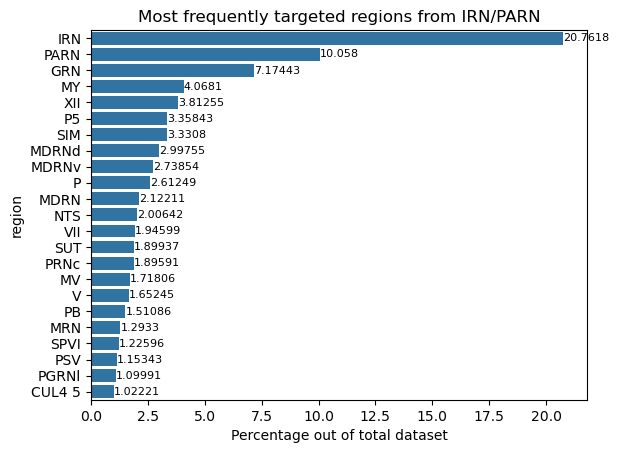

In [ ]:
#exclude mossy fibers from this? i dont think its necessary
x = [k for k, _ in perc_thresh]
y = [v for _, v in perc_thresh]
ax = sns.barplot(x=y, y=x)
ax.bar_label(ax.containers[0], fontsize=8)
ax.set(title='Most frequently targeted regions from IRN/PARN', xlabel='Percentage out of total dataset', ylabel='region')

In [22]:
#data preprocessing
frequency_ppd = preprocess(frequency_data)
#length_ppd = preprocess(length_data)
frequency_tocluster = frequency_ppd.T
#length_tocluster = length_ppd.T
frequency_tocluster = frequency_tocluster.sort_index(axis=0) #this separates ipsi v contra but for freq the clusters looked cleaner w/o sorting

In [31]:
#setting lists so I can get ontology information for each region
regions = frequency_ppd.keys()
regions_target_contra = []
regions_target_ipsi = []
for region in regions:
    expi = 'Ipsilateral'
    expc = 'Contralateral'
    if expi in region:
        reg = region.replace(expi+' ', '')
        regions_target_ipsi.append(reg)
    if expc in region:
        reg2 = region.replace(expc+' ', '')
        regions_target_contra.append(reg2)
regions_target_ipsi.remove('Other')
regions_target_contra.remove('Other')
regions_target_ipsi.remove('wholebrain')
#regions_target_contra.remove('wholebrain')
for i, region in enumerate(regions_target_ipsi):
    if region == 'CUL4 5':
        regions_target_ipsi[i] = 'CUL4, 5'
for i, region in enumerate(regions_target_contra):
    if region == 'CUL4 5':
        regions_target_contra[i] = 'CUL4, 5'
#print(regions_target)
parent_regions_ipsi = []
parent_regions_contra = []
for val in regions_target_contra:
    parent_regions_contra.append(ccf_v3_10um.structures[val]['structure_id_path'][-2])
#print(parent_regions)
for val in regions_target_ipsi:
    parent_regions_ipsi.append(ccf_v3_10um.structures[val]['structure_id_path'][-2])
#print(parent_regions)

In [145]:
#get each region with parent ontology level (might have to do this manually since some regions don't have the tag I want)
tandp_contra = list(zip(regions_target_contra, parent_regions_contra))
#sorting just gets it so all regions that have the same parent region are grouped together
sorted_contra = sorted(tandp_contra, key=lambda item: item[1])
#print(sorted_contra)
tandp_ipsi = list(zip(regions_target_ipsi, parent_regions_ipsi))
sorted_ipsi = sorted(tandp_ipsi, key=lambda item: item[1])
#print(sorted_ipsi)
ip_then_cont = sorted_ipsi + sorted_contra
#print(ip_then_cont)
i_to_c_correct_regions = []
for info in ip_then_cont:
    region, parent = info
    parent_path = ccf_v3_10um.structures[region]["structure_id_path"]
    if len(parent_path) <= 4:
        i_to_c_correct_regions.append((region, ccf_v3_10um.structures[parent_path[-1]]['acronym']))
    else:
        i_to_c_correct_regions.append((region, ccf_v3_10um.structures[parent_path[4]]['acronym']))
sorted_ic = sorted(i_to_c_correct_regions, key=lambda item: item[1])
row_labels = [info[1] for info in sorted_ic]
print(row_labels)

['AQ', 'CB', 'CB', 'CTXpl', 'CTXpl', 'CTXpl', 'CTXpl', 'CTXpl', 'CTXpl', 'CTXpl', 'CTXpl', 'CTXpl', 'CTXpl', 'CTXpl', 'CTXpl', 'CTXpl', 'CTXpl', 'CTXsp', 'CTXsp', 'CTXsp', 'DN', 'DN', 'FN', 'FN', 'HEM', 'HEM', 'HEM', 'HEM', 'HEM', 'HEM', 'HEM', 'HEM', 'HEM', 'HEM', 'HEM', 'HEM', 'HY', 'HY', 'HY', 'HY', 'HY', 'HY', 'HY', 'HY', 'HY', 'HY', 'HY', 'HY', 'HY', 'HY', 'HY', 'HY', 'HY', 'HY', 'HY', 'HY', 'IP', 'IP', 'MB', 'MB', 'MBmot', 'MBmot', 'MBmot', 'MBmot', 'MBmot', 'MBmot', 'MBmot', 'MBmot', 'MBmot', 'MBmot', 'MBmot', 'MBmot', 'MBmot', 'MBmot', 'MBmot', 'MBmot', 'MBmot', 'MBmot', 'MBmot', 'MBmot', 'MBmot', 'MBmot', 'MBmot', 'MBmot', 'MBmot', 'MBmot', 'MBmot', 'MBmot', 'MBmot', 'MBmot', 'MBmot', 'MBsen', 'MBsen', 'MBsen', 'MBsen', 'MBsen', 'MBsen', 'MBsen', 'MBsen', 'MBsta', 'MBsta', 'MBsta', 'MBsta', 'MBsta', 'MBsta', 'MBsta', 'MBsta', 'MY', 'MY', 'MY', 'MY', 'MY', 'MY', 'MY', 'MY', 'MY', 'MY', 'MY', 'MY', 'MY', 'MY', 'MY', 'MY', 'MY', 'MY', 'MY', 'MY', 'MY', 'MY', 'MY', 'MY', 'MY', 'MY

In [ ]:
for i, region in enumerate(row_labels)

In [138]:
unique = []
for region in row_labels:
    if region not in unique:
        unique.append(region)
    else:
        continue
print(len(unique))
print(unique)

53
['AQ', 'CB', 'CTXpl', 'CTXsp', 'DN', 'FN', 'HEM', 'HY', 'IP', 'MB', 'MBmot', 'MBsen', 'MBsta', 'MY', 'P', 'PAL', 'STR', 'TH', 'V3', 'V4', 'V4r', 'VERM', 'VIIn', 'VL', 'VeCB', 'act', 'amc', 'arb', 'bsc', 'c', 'cVIIIn', 'cett', 'chpl', 'cpd', 'csc', 'fa', 'fiber tracts', 'fxs', 'gVIIn', 'icp', 'mcp', 'mfbse', 'mlf', 'nst', 'pc', 'py', 'pyd', 'rust', 'sV', 'scp', 'ts', 'tspc', 'vVIIIn']


In [146]:
ccf_v3_10um.structures['CTXpl']['structure_id_path']

[997, 8, 567, 688, 695]

In [141]:
ccf_v3_10um.structures[140]


{
    'acronym': 'AQ',
    'id': 140,
    'name': 'cerebral aqueduct',
    'structure_id_path': [997, 73, 140],
    'rgb_triplet': [170, 170, 170],
    'mesh_filename': WindowsPath('C:/Users/samkr/.brainglobe/allen_mouse_10um_v1.2/meshes/140.obj'),
    'mesh': <meshio mesh object>
  Number of points: 521
  Number of cells:
    triangle: 1034
  Point data: obj:vn
  Cell data: obj:group_ids
}

In [137]:
#testing what color labels should be
iris = sns.load_dataset("iris")
species = iris.pop("species")
lut = dict(zip(species.unique(), "rbg"))
print(lut)
row_colors = species.map(lut)
print(row_colors)
unique = []
for color in row_colors:
    if color not in unique:
        unique.append(color)
    else:
        continue
print(len(unique))

{'setosa': 'r', 'versicolor': 'b', 'virginica': 'g'}
0      r
1      r
2      r
3      r
4      r
      ..
145    g
146    g
147    g
148    g
149    g
Name: species, Length: 150, dtype: object
3


In [ ]:
#to get the colors to be correct i may have to manually assign a color to each region, and manually assign region groups since ontology level isn't consistent
sns.clustermap(frequency_tocluster, 
                method='ward', 
                metric='euclidean', 
                row_cluster=False,
                dendrogram_ratio=(.1, .15),
                cbar_pos=(0, .15, .03, .7),
                cbar_kws={'label': 'ln(terminals in region + 1)'},
                yticklabels=True,
                xticklabels=True,
                row_colors=row_labels)

ValueError: Invalid RGBA argument: 'A'

<Figure size 1000x1000 with 0 Axes>

c:\Users\samkr\.local\share\mamba\envs\reconstructions\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


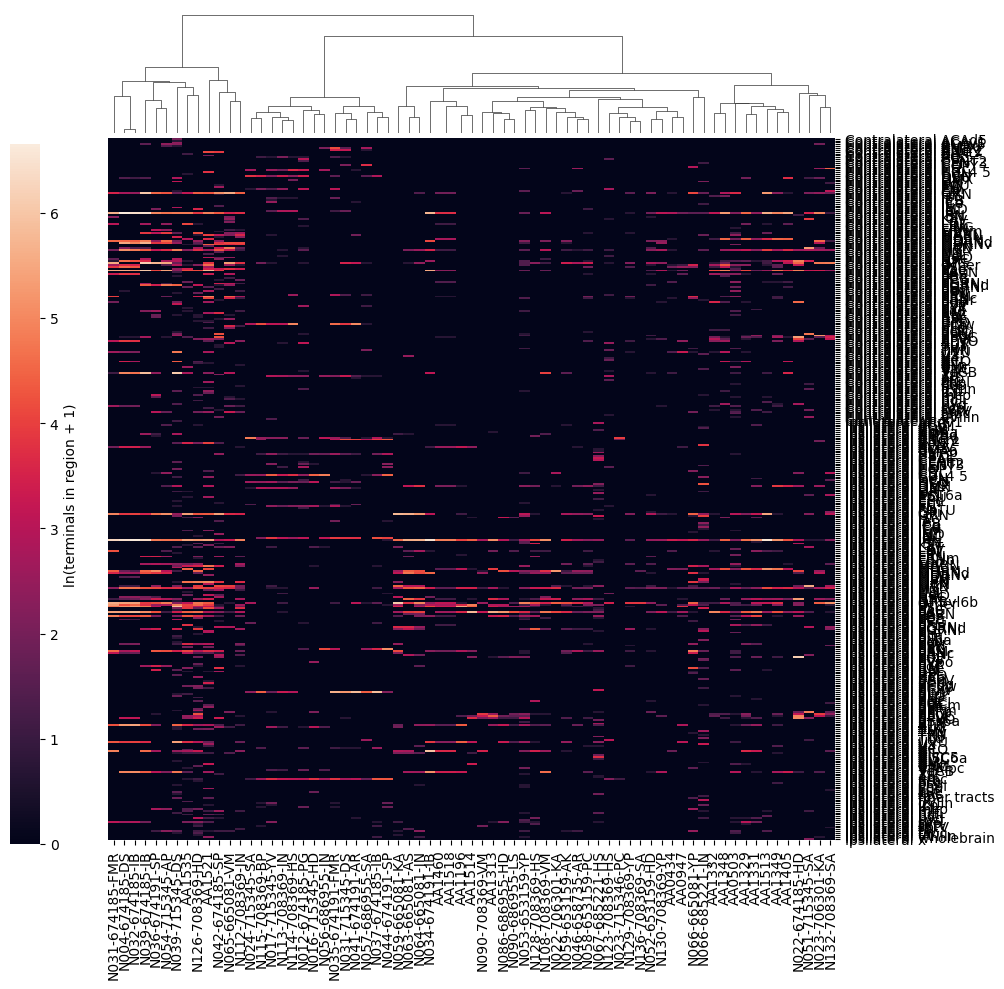

In [127]:
#hierarchical clustering on freq dataset
cmap_freq = cluster_and_plot(frequency_tocluster, row_colors=row_labels)
#cmap.plot()
#plt.show()

In [ ]:
#tbh unnecessary work just wanted to work my python skills but its not worth the time rn
selector = VarianceThreshold(threshold=0.0).set_output(transform='pandas')
freq_hasvar = selector.fit_transform(frequency_data)
#print(freq_hasvar.head())
thresh = 5
mask = (freq_hasvar > 0) & (freq_hasvar <= thresh)
#print(mask.head())
rois = []
for i, row in mask.iterrows():
    rowroi = []
    for col, val in row.items():
        if val is True:
            rowroi.append((col, val))
        rois.append(rowroi)
print(rois)

[[('Ipsilateral MDRNd', True), ('Ipsilateral NTS', True), ('Ipsilateral PRNr', True), ('Ipsilateral MEV', True), ('Ipsilateral PCG', True), ('Ipsilateral MV', True), ('Contralateral scp', True), ('Contralateral PPN', True), ('Contralateral SPVI', True), ('Contralateral DMX', True)], [('Ipsilateral MDRNd', True), ('Ipsilateral NTS', True), ('Ipsilateral PRNr', True), ('Ipsilateral MEV', True), ('Ipsilateral PCG', True), ('Ipsilateral MV', True), ('Contralateral scp', True), ('Contralateral PPN', True), ('Contralateral SPVI', True), ('Contralateral DMX', True)], [('Ipsilateral MDRNd', True), ('Ipsilateral NTS', True), ('Ipsilateral PRNr', True), ('Ipsilateral MEV', True), ('Ipsilateral PCG', True), ('Ipsilateral MV', True), ('Contralateral scp', True), ('Contralateral PPN', True), ('Contralateral SPVI', True), ('Contralateral DMX', True)], [('Ipsilateral MDRNd', True), ('Ipsilateral NTS', True), ('Ipsilateral PRNr', True), ('Ipsilateral MEV', True), ('Ipsilateral PCG', True), ('Ipsilater

c:\Users\samkr\.local\share\mamba\envs\reconstructions\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


TypeError: Image data of dtype object cannot be converted to float

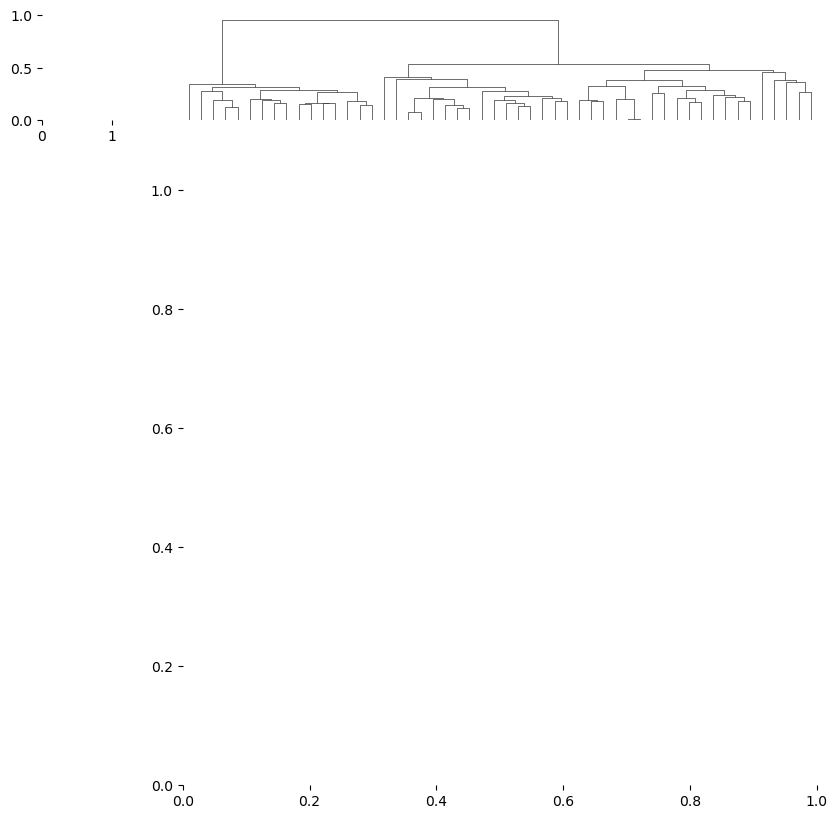

In [ ]:
#hierarchical clustering on the length dataset
#this is not working correctly atm for whatever reason, ill leave it be for now i think
#just don't worry about this for a bit lmao
#length_tocluster = length_tocluster.sort_index(axis=0)
#cmap_length = cluster_and_plot(length_tocluster)
sns.clustermap(length_tocluster, 
                method='ward', 
                metric='euclidean', 
                row_cluster=False,
                dendrogram_ratio=(.1, .15),
                cbar_pos=(0, .15, .03, .7),
                cbar_kws={'label': 'ln(terminals in region + 1)'},
                yticklabels=True,
                xticklabels=True)

In [35]:
help(cmap)

Help on ClusterGrid in module seaborn.matrix object:

class ClusterGrid(seaborn.axisgrid.Grid)
 |  ClusterGrid(data, pivot_kws=None, z_score=None, standard_scale=None, figsize=None, row_colors=None, col_colors=None, mask=None, dendrogram_ratio=None, colors_ratio=None, cbar_pos=None)
 |  
 |  Method resolution order:
 |      ClusterGrid
 |      seaborn.axisgrid.Grid
 |      seaborn.axisgrid._BaseGrid
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, data, pivot_kws=None, z_score=None, standard_scale=None, figsize=None, row_colors=None, col_colors=None, mask=None, dendrogram_ratio=None, colors_ratio=None, cbar_pos=None)
 |      Grid object for organizing clustered heatmap input on to axes
 |  
 |  dim_ratios(self, colors, dendrogram_ratio, colors_ratio)
 |      Get the proportions of the figure taken up by each axes.
 |  
 |  format_data(self, data, pivot_kws, z_score=None, standard_scale=None)
 |      Extract variables from data or use directly.
 |  
 |  plo